In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Libary

In [2]:
!pip install octopus-ml

In [3]:
import warnings
warnings.simplefilter("ignore")
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import tracemalloc
import pandas as pd
import numpy as np
import os
import glob
import octopus_ml as oc
%matplotlib inline

label = {"nor": 0, "mal" : 2, "susp" : 1}
input_folder = "/content/drive/My Drive/AI/report_2021/data"

# Load data

In [4]:
def getListTask(folder_name, label):
  df = pd.DataFrame() 
  for root, dir, file in os.walk(folder_name):
    for f in file:
      if '.csv' in f:
        print(os.path.join(root, f))
        df = pd.concat([df, pd.read_csv(os.path.join(root, f))], sort=False)
    data = list(set(df["task"].to_list())) 
    labels = [label for i in range(len(data))]
    return df, pd.DataFrame({"task":data, "label": labels}, columns= ["task", "label"])

In [5]:
process_data = pd.DataFrame() 
task_data = pd.DataFrame() 
for root, dir, file in os.walk(input_folder):
  for d in dir:
    df_process, df_task =  getListTask(os.path.join(root, d),label[d] )
    process_data = pd.concat([process_data, df_process], sort=False)
    task_data = pd.concat([task_data, df_task], sort=True)
print(process_data.shape[0], task_data.shape[0])

/content/drive/My Drive/AI/report_2021/data/mal/final_mal_1703.csv
/content/drive/My Drive/AI/report_2021/data/susp/final_suci_1703.csv
/content/drive/My Drive/AI/report_2021/data/nor/final_nor_1703.csv
1483417 158059


In [6]:
process_data["Scores_Network"] = process_data["Scores_Network"].astype(int)
process_data["Autostart"] = process_data["Autostart"].astype(int)
process_data["LowAccess"] = process_data["LowAccess"].astype(int)
process_data["ProcessType"] = process_data["ProcessType"].astype("category").cat.codes + 1
process_data["FileType"] = process_data["FileType"].astype("category").cat.codes + 1
process_data = process_data.drop(["Unnamed: 60"], axis=1)

In [ ]:
process_data.sample(5)

,task,CreationTimestamp,ProcessID,ParentPID,CommandLine,Image,ProcessType,Registry,Files,Modules,DroppedFiles,DebugStrings,EventsCounters_Network,Scores_Network,Autostart,LowAccess,FileType,Priority,totalDropFileSize,unknown_ip,Suspicious_ip,Malicious_ip,whitelist_ip,unsafe_ip,unknown_domain,Suspicious_domain,Malicious_domain,whitelist_domain,unsafe_domain,unknown_http_request,Suspicious_http_request,Malicious_http_request,whitelist_http_request,unsafe_http_request,HKEY_LOCAL_MACHINE,HKEY_CLASSES_ROOT,HKEY_USERS,HKEY_CURRENT_CONFIG,HKEY_CURRENT_USER,startup_registry_keys,active_setup_registry_keys,services_registry_keys,dll_injection_registry_keys,shell_spawning_registry_keys,internet_settings_registry_keys,bho_registry_keys,executable,text,html,image,xml,$WinREAgent,OneDriveTemp,PerfLogs,Program Files,Program Files(x86),ProgramData,Windows,$RECYCLE.BIN,Users,label
3832,a9cc0f9f-23e6-4cba-8331-6c0c49731981,1533131290916,2764,2208,taskkill /IM twssrv.exe /T /F,C:\Windows\system32\taskkill.exe,1,3,191,84,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97007,e9802dd6-7503-4541-acaa-5b88605b037b,1604257922571,2456,592,C:\Windows\System32\vdsldr.exe -Embedding,C:\Windows\System32\vdsldr.exe,3,2,130,66,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
324159,550a0e14-ed27-41dc-8524-65e80fc93e3e,1581991142076,3452,3084,"""C:\Windows\system32\dllhost.exe""",C:\Windows\system32\dllhost.exe,1,0,4,4,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37033,bf8f33c5-c2ae-441a-9251-56744c09000b,1607714085317,1628,3200,"""C:\Program Files\Google\Chrome\Application\ch...",C:\Program Files\Google\Chrome\Application\chr...,1,0,317,118,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
632703,a639b661-79d1-4932-b4c4-88a554ef2fbb,1597916828368,672,2692,fsutil file createnew C:\temp\file203.txt 112...,C:\Windows\system32\fsutil.exe,1,0,62,40,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Categorical features

In [ ]:
categorical_features=[]
for c in process_data.columns:
    col_type = process_data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        process_data[c] = process_data[c].astype('category')
        categorical_features.append(c)
print (categorical_features)

# Label distribution

In [ ]:
process_data['label'].value_counts()

0    831056
3    301723
2    177916
1    172722
Name: label, dtype: int64

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
(process_data.label.value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'])
display(process_data.label.value_counts(normalize=True)*100)
ax.set_ylim([0, 100])
ax.set_ylabel('Percentage of Patients[%]', fontsize=14)
ax.set_xticklabels(['Unknow','No threat', 'Suspicious', 'Malicious'], fontsize=14, rotation=0)
plt.show()

In [ ]:
print(process_data.shape)

(1483231, 46)


# Graph Feature

In [ ]:
fig, axes = plt.subplots(ncols=len(process_data.columns), figsize=(50,25))
for ax, col in zip(axes, process_data.columns):
  sns.distplot(process_data[col], ax=ax)
  plt.tight_layout() 
plt.show()

In [ ]:
sns.displot(data = process_data, kind = 'hist', x = 'unknown_domain', hue = 'label', multiple="dodge")
sns.displot(data = process_data, kind = 'hist', x = 'Autostart', hue = 'label', multiple="dodge")
sns.displot(data = process_data, kind = 'hist', x = 'Scores_Network', hue = 'label', multiple="dodge")
sns.displot(data = process_data, kind = 'hist', x = 'DebugStrings', hue = 'label', multiple = "dodge")

In [ ]:
sns.displot(data = process_data, kind = 'hist', x = 'unknown_ip', hue = 'label', multiple="dodge",bins=25,height = 4, aspect = 1.7)
sns.displot(data = process_data, kind = 'hist', x = 'Suspicious_ip', hue = 'label', multiple="dodge",bins=25,height = 4, aspect = 1.7)
sns.displot(data = process_data, kind = 'hist', x = 'Malicious_ip', hue = 'label', multiple="dodge",bins=25,height = 4, aspect = 1.7)

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(3,4))
sns.set_context("paper", font_scale=1.2)   
sns.factorplot(x="LowAccess", y="Autostart", hue="label", data=process_data, kind="bar",height = 4, aspect = 2.3)

In [ ]:
plt.style.use('fivethirtyeight')
sns.set_context("paper", font_scale=1.1)   
gcbest = ["#3498db", "#2ecc71"]
sns.set_palette(gcbest,20)
sns.factorplot(x="Autostart", y="label", data=process_data, kind="bar",height = 4, aspect = 2.3)

In [ ]:
plt.style.use('fivethirtyeight')
sns.set_context("paper", font_scale=1.1)   
gcbest = ["#3498db", "#2ecc71"]
sns.set_palette(gcbest,20)
sns.factorplot(x="LowAccess", y="label", data=process_data, kind="bar")

In [ ]:
print(f"There are {len(process_data[process_data.OneDriveTemp >0])} data points in the training data set with OneDriveTemp .")
print(f"There are {len(process_data[process_data.PerfLogs >0])} data points in the training data set with PerfLogs")
# display(process_data[process_data.Autostart>0])


There are 0 data points in the training data set with OneDriveTemp .
There are 734 data points in the training data set with PerfLogs


In [ ]:
print(f"There are {len(process_data[process_data.label == 2])} data points in the training data set with ")

# display(process_data[process_data.LowAccess>0])

There are 0 data points in the training data set with 


# Extract

In [7]:
process_data["ip"] = (process_data["whitelist_ip"] * 3 + process_data["unsafe_ip"] * 4 + process_data["Malicious_ip"] * 2 + process_data["Suspicious_ip"] * 1 + process_data["unknown_ip"] * 0) / 5
process_data["domain"] = (process_data["whitelist_domain"] * 3 + process_data["unsafe_domain"] * 4 + process_data["Malicious_domain"] * 2 + process_data["Suspicious_domain"] * 1 + process_data["unknown_domain"] * 0) /5
process_data["http_request"] = (process_data["whitelist_http_request"] * 3 + process_data["unsafe_http_request"] * 4 + process_data["Malicious_http_request"] * 2 + process_data["Suspicious_http_request"] * 1 + process_data["unknown_http_request"] * 0 ) /5


In [8]:
process_data.loc[(process_data['label'] == 2)] = 3
process_data.loc[(process_data['label'] == 0)] = 1

In [ ]:
process_data.sample(5)

,task,CreationTimestamp,ProcessID,ParentPID,CommandLine,Image,ProcessType,Registry,Files,Modules,DroppedFiles,DebugStrings,EventsCounters_Network,Scores_Network,Autostart,LowAccess,FileType,Priority,totalDropFileSize,unknown_ip,Suspicious_ip,Malicious_ip,whitelist_ip,unsafe_ip,unknown_domain,Suspicious_domain,Malicious_domain,whitelist_domain,unsafe_domain,unknown_http_request,Suspicious_http_request,Malicious_http_request,whitelist_http_request,unsafe_http_request,HKEY_LOCAL_MACHINE,HKEY_CLASSES_ROOT,HKEY_USERS,HKEY_CURRENT_CONFIG,HKEY_CURRENT_USER,startup_registry_keys,active_setup_registry_keys,services_registry_keys,dll_injection_registry_keys,shell_spawning_registry_keys,internet_settings_registry_keys,bho_registry_keys,executable,text,html,image,xml,$WinREAgent,OneDriveTemp,PerfLogs,Program Files,Program Files(x86),ProgramData,Windows,$RECYCLE.BIN,Users,label,ip,domain,http_request
567026,d0bb8eb5-4166-4e20-b192-1d72db7283ce,1594957929164,1204,472,C:\Windows\servicing\TrustedInstaller.exe,C:\Windows\servicing\TrustedInstaller.exe,9,5,289,59,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0
697347,f36d934b-c5a0-47df-ac5e-0a0aa88bfe5d,1563972431842,3884,284,"""C:\Windows\system32\NOTEPAD.EXE"" C:\Users\adm...",C:\Windows\system32\NOTEPAD.EXE,6,14,92,25,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
310503,fdceb9b6-535b-409f-98ab-4cccd39a824f,1603911600339,2936,2984,"""C:\Program Files\Google\Chrome\Application\ch...",C:\Program Files\Google\Chrome\Application\chr...,1,0,450,118,1,0,0,0,0,0,2,0,715,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
598117,a3b9cab4-e4e1-4d03-933e-2e9ff41dc801,1592925321227,2148,2972,C:\Windows\system32\cmd.exe /c net view \\192....,C:\Windows\system32\cmd.exe,1,6,189,26,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0
323427,4fffded7-a69a-4f1c-ac64-24b0f33f94e1,1612079271027,2312,292,"""C:\Users\admin\AppData\Local\Temp\PURCHASE OR...",C:\Users\admin\AppData\Local\Temp\PURCHASE ORD...,6,1,859,124,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


# Save 

In [18]:
process_data.to_csv("/content/drive/My Drive/AI/Code/report_2021/EDA.csv", index=False)

# Model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

task_data = task_data.sample(frac=1).reset_index(drop=True)
X_task_train, X_task_test, Y_task_train, Y_task_test = train_test_split(task_data["task"], task_data["label"],test_size=0.2)

list_of_task_train = X_task_train.tolist()
list_of_task_test = X_task_test.tolist()

process_train = process_data[process_data['task'].isin(list_of_task_train)]
process_test = process_data[process_data['task'].isin(list_of_task_test)]
# process_train = process_train.sample(frac=1).reset_index(drop=True)
process_test = process_test.sort_values(by='task')

Y_process_train = process_train['label']
X_process_train = process_train.drop(['label', 'task',  'ProcessID', 'ParentPID', 'CommandLine', 'Image' ,'DebugStrings'], axis = 1)

Y_process_test= process_test['label']
X_process_test = process_test.drop(['label', 'task',  'ProcessID', 'ParentPID', 'CommandLine', 'Image','DebugStrings'], axis = 1)


In [16]:
model = RandomForestClassifier(n_estimators=10)
model.fit(X_process_train,Y_process_train)
y_process_pred = model.predict(X_process_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
print(classification_report(Y_process_test,y_process_pred))
print(accuracy_score(Y_process_test,y_process_pred))
print(confusion_matrix(Y_process_test,y_process_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.98     34724
           3       0.99      0.99      0.99     64550

    accuracy                           0.99     99274
   macro avg       0.98      0.98      0.98     99274
weighted avg       0.99      0.99      0.99     99274

0.9850917662227774
[[34128   596]
 [  884 63666]]


<Figure size 432x288 with 0 Axes>

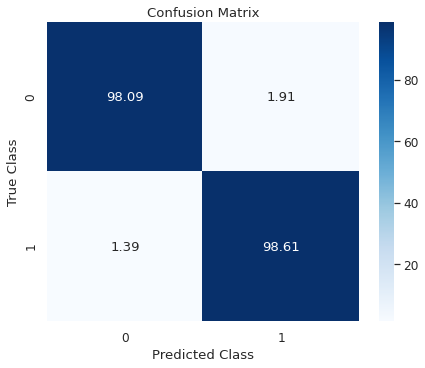

<Figure size 432x288 with 0 Axes>

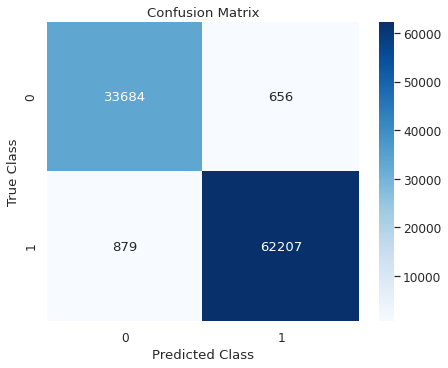

In [12]:
oc.confusion_matrix_plot(Y_process_test,y_process_pred)